In [18]:
!pip install lifetimes

In [19]:
from lifetimes.datasets import load_cdnow_summary
data = load_cdnow_summary(index_col=[0])

In [20]:
data.shape

(2357, 3)

In [21]:
import pandas as pd
import numpy as np

In [22]:
# data = pd.read_csv('/content/DFORE115lifetimesrfm.csv', low_memory=False)

In [23]:
data.head()

,frequency,recency,T
ID,,,
1,2,30.43,38.86
2,1,1.71,38.86
3,0,0.00,38.86
4,0,0.00,38.86
5,0,0.00,38.86


In [24]:
# data.recency= data.recency.abs()
# data['T']= data['T'].abs()

In [25]:
# data= data.loc[data.payment_type=='App']

In [26]:
from lifetimes import BetaGeoFitter
import lifetimes

# similar API to scikit-learn and lifelines.
bgf = lifetimes.BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.79, alpha: 4.41, b: 2.43, r: 0.24>


In [27]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.242593,0.012557,0.217981,0.267205
alpha,4.413532,0.378221,3.672218,5.154846
a,0.792886,0.185719,0.428877,1.156895
b,2.425752,0.705345,1.043276,3.808229


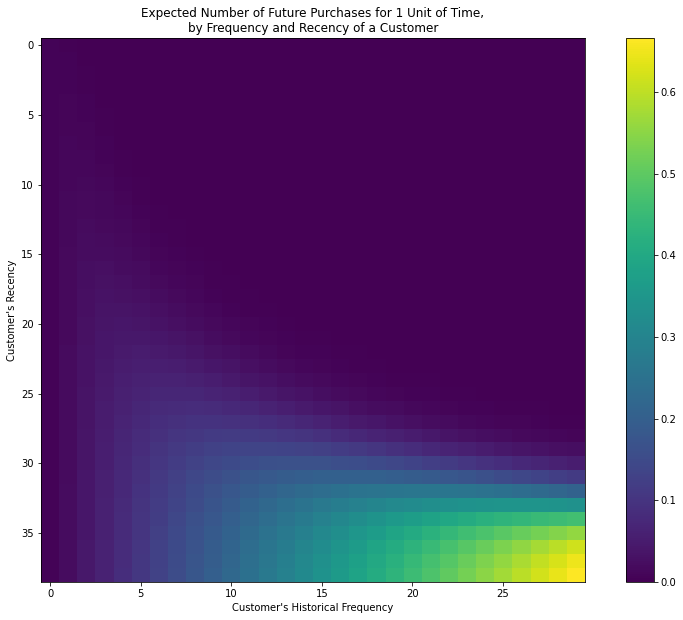

In [28]:
from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,10))
plot_frequency_recency_matrix(bgf)

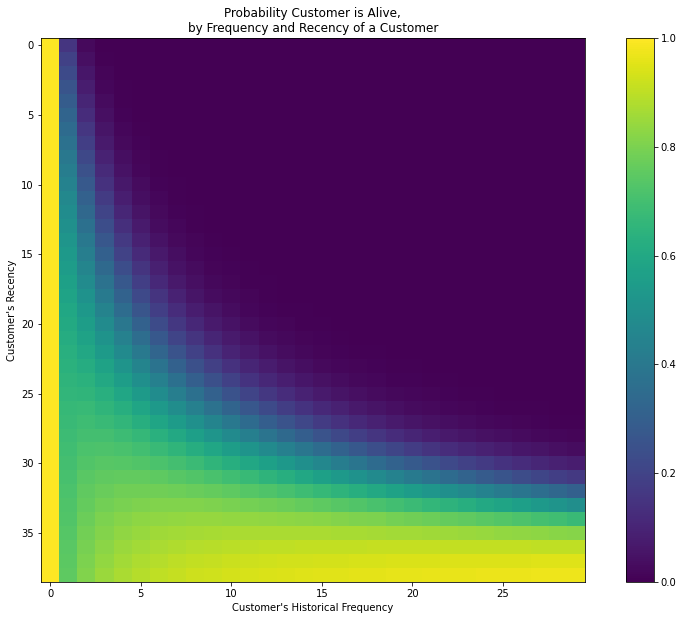

In [29]:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(15,10))
plot_probability_alive_matrix(bgf)

In [30]:
t = 30
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,predicted_purchases
ID,,,,
509,18,35.14,35.86,10.371749
1981,17,28.43,28.86,11.491309
841,19,34.00,34.14,11.494015
157,29,37.71,38.00,16.214572
1516,26,30.86,31.00,16.874310


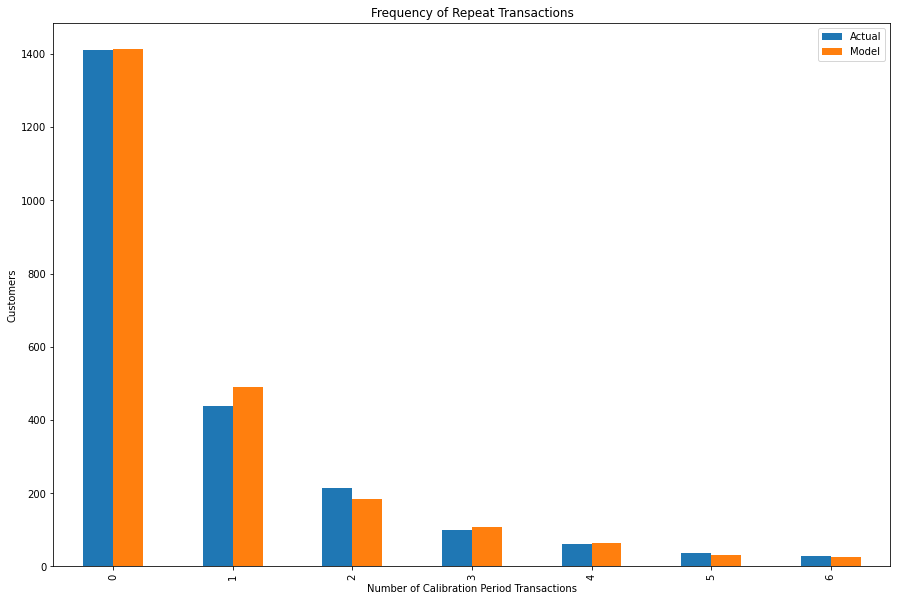

In [31]:
from lifetimes.plotting import plot_period_transactions
fig, ax = plt.subplots(figsize=(15,10))
plot_period_transactions(bgf, ax=ax)

In [32]:
from lifetimes.datasets import load_transaction_data
from lifetimes.utils import summary_data_from_transaction_data

transaction_data = load_transaction_data()
# print(transaction_data.head())
summary = summary_data_from_transaction_data(transaction_data, 'id', 'date', observation_period_end='2014-12-31')


In [33]:
summary.head()

,frequency,recency,T
id,,,
0,0.0,0.0,298.0
1,0.0,0.0,224.0
2,6.0,142.0,292.0
3,0.0,0.0,147.0
4,2.0,9.0,183.0


In [34]:
# summary_cal_holdout.shape
summary.shape

(5000, 3)

In [35]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(transaction_data, 'id', 'date',
                                        calibration_period_end='2014-09-01',
                                        observation_period_end='2014-12-31' )
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
id,,,,,
0,0.0,0.0,177.0,0.0,121.0
1,0.0,0.0,103.0,0.0,121.0
2,6.0,142.0,171.0,0.0,121.0
3,0.0,0.0,26.0,0.0,121.0
4,2.0,9.0,62.0,0.0,121.0


In [36]:
summary_cal_holdout.loc[summary_cal_holdout.frequency_holdout!=0]

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
id,,,,,
20,0.0,0.0,38.0,2.0,121.0
22,1.0,68.0,107.0,3.0,121.0
35,7.0,38.0,63.0,9.0,121.0
84,2.0,54.0,155.0,3.0,121.0
88,3.0,101.0,142.0,4.0,121.0
...,...,...,...,...,...
4950,15.0,121.0,123.0,13.0,121.0
4962,5.0,88.0,96.0,8.0,121.0
4967,2.0,83.0,118.0,1.0,121.0


In [37]:
sum(summary_cal_holdout.frequency_cal!=0)

2405

In [38]:
# data.columns= ['branch_id', 'client_account_id', 'payment_type', 'namedUser',
#        'frequency_cal', 'recency_cal', 'monetary_value', 'T_cal', 'frequency_holdout',
#        'duration_holdout', 'predicted_purchases']

In [39]:
summary_cal_holdout['pred_num_txn']=bgf.predict(30, summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])

In [40]:
summary_cal_holdout['predicted_purchases']= t*summary_cal_holdout.frequency_cal/372

In [41]:
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,pred_num_txn,predicted_purchases
id,,,,,,,
0,0.0,0.0,177.0,0.0,121.0,0.039152,0.000000
1,0.0,0.0,103.0,0.0,121.0,0.065088,0.000000
2,6.0,142.0,171.0,0.0,121.0,0.763235,0.483871
3,0.0,0.0,26.0,0.0,121.0,0.211236,0.000000
4,2.0,9.0,62.0,0.0,121.0,0.097957,0.161290


In [42]:
summary_cal_holdout.shape

(5000, 7)

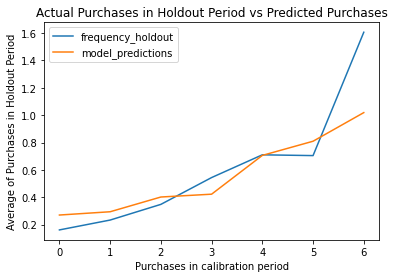

In [43]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In [ ]:
t = 30 #predict purchases in 10 periods
individual = data.iloc[20]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency_cal'], individual['recency_cal'], individual['T_cal'])
# 0.0576511

0.09922677403409648

In [ ]:
from lifetimes.plotting import plot_history_alive

id = 35
days_since_birth = 200
sp_trans = data.loc[data['namedUser'] == '1239655']
plot_history_alive(bgf, days_since_birth, sp_trans, 'date')

KeyError: ignored

In [ ]:
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value

summary_with_money_value = load_cdnow_summary_data_with_monetary_value()
summary_with_money_value.head()
returning_customers_summary = summary_with_money_value[summary_with_money_value['frequency']>0]

print(returning_customers_summary.head())

             frequency  recency      T  monetary_value
customer_id                                           
1                    2    30.43  38.86           22.35
2                    1     1.71  38.86           11.77
6                    7    29.43  38.86           73.74
7                    1     5.00  38.86           11.77
9                    2    35.71  38.86           25.55


In [ ]:
data[['monetary_value', 'frequency_cal']].corr()

,monetary_value,frequency_cal
monetary_value,1.000000,-0.100862
frequency_cal,-0.100862,1.000000


In [ ]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 946 subjects, p: 6.25, q: 3.74, v: 15.45>


In [ ]:
print(ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    ).head(10))

customer_id
1     24.658616
2     18.911480
3     35.171002
4     35.171002
5     35.171002
6     71.462851
7     18.911480
8     35.171002
9     27.282408
10    35.171002
dtype: float64


In [ ]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    ).mean(),
    summary_with_money_value[summary_with_money_value['frequency']>0]['monetary_value'].mean()
))

Expected conditional average profit: 35.252958176050115, Average profit: 35.07855179704026


In [ ]:
# refit the BG model to the summary_with_money_value dataset
bgf.fit(summary_with_money_value['frequency'], summary_with_money_value['recency'], summary_with_money_value['T'])

print(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    summary_with_money_value['frequency'],
    summary_with_money_value['recency'],
    summary_with_money_value['T'],
    summary_with_money_value['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
).head(10))

customer_id
1      140.096218
2       18.943466
3       38.180575
4       38.180575
5       38.180575
6     1003.868285
7       28.109681
8       38.180575
9      167.418224
10      38.180575
Name: clv, dtype: float64
